In [1]:
suppressPackageStartupMessages(library("ridge"))
suppressPackageStartupMessages(library("sva"))
suppressPackageStartupMessages(library("car"))
suppressPackageStartupMessages(library("preprocessCore"))
suppressPackageStartupMessages(library("ROCR"))
suppressPackageStartupMessages(library("GEOquery"))
suppressPackageStartupMessages(library("MLmetrics"))
suppressPackageStartupMessages(library("PRROC"))
suppressPackageStartupMessages(library("plyr"))
source("../Geeleher_with_GDSCr6/scripts/compute_phenotype_function.R")
source("../Geeleher_with_GDSCr6/scripts/summarizeGenesByMean.R")
source("../Geeleher_with_GDSCr6/scripts/homogenize_data.R")
source("../Geeleher_with_GDSCr6/scripts/do_variable_selection.R")

In [2]:
root_dir <- "../../v2/"
# You can play with the preprocessing but the following is what Geeleher et al. 2014 used:
powTransP=TRUE
lowVarGeneThr=0.2
# Number of permutations <---- not used  
NUM_PERM=10000


In [3]:
group_compare_plot <- function(predictedResp,knownRespGroups, 
                        plot_title="",plot_ylab="logIC50",cohort=""){
    # predictedResp is a list of predicted IC50 with sample names in names
    # knownRespGroups is a table with samples in rownames and column "response" with R and S

    R_samples <- row.names(knownRespGroups[knownRespGroups["response"] == "R",])
    S_samples <-  row.names(knownRespGroups[knownRespGroups["response"] == "S",])
    predictedRespGrouped <- list("Resistant"=predictedResp[R_samples],
                                  "Sensitive"=predictedResp[S_samples])
    
    boxplot(predictedRespGrouped, outline=FALSE, border="grey", 
            ylab="logIC50",
            main=plot_title)
    stripchart(predictedRespGrouped , vertical=TRUE, pch=20, method="jitter", add=TRUE)
    # T-test whether logIC50 in R is greater than in S group
    #ttest_res <- t.test(predictedRespGrouped$"Resistant",predictedRespGrouped$"Sensitive", alternative="greater")
    #cat(cohort,"\n\tT-test p-value:", ttest_res$p.value,
    #"\n\tCI95%:",ttest_res$conf.int,
    #"\n\tmeans:",ttest_res$estimate,"\n")
    return (predictedRespGrouped)
}

run_Geelehers_method <- function(testDataFile,testResponseFile,trainingDataFile,trainingResponseFile,
                       powTransP=TRUE,lowVarGeneThr=0.2,cohort=cohort,drug=drug){
    # read training data and reorder 
    trainingData <- read.csv(trainingDataFile, as.is=TRUE, check.names=FALSE,sep = "\t", row.names = 1, header= TRUE)
    trainingResponse <- read.csv(trainingResponseFile, as.is=TRUE, check.names=FALSE,sep = "\t", row.names = 1, header= TRUE)
    trainingData <- as.matrix(trainingData[,row.names(trainingResponse)])
    #trainingData <- 2^trainingData
    trainingI50 <- trainingResponse$logIC50
    names(trainingI50 ) <- rownames(trainingResponse)
    
    
    # read testing data and reorder 
    testData <- read.table(testDataFile,sep = "\t", row.names = 1, header= TRUE,as.is=TRUE, check.names=FALSE)
    testResponse <- read.csv(testResponseFile, as.is=TRUE, check.names=FALSE,sep = "\t", row.names = 1, header= TRUE)
    testData <- as.matrix(testData[,row.names(testResponse)])
    #testData <- 2^testData
    
    # statistics
    shared_genes = intersect(row.names(trainingData),row.names(testData))
    cat(paste0(cohort," ",drug,"\n"))
    cat(paste0("genes in training cohort: ", dim(trainingData)[1],"\tsamples: ", dim(trainingData)[2],"\n",
               "genes in testing cohort: ", dim(testData)[1],"\tsamples: ", dim(testData)[2],"\n",
               "shared:", length(shared_genes),"\n"))
    
    # predict response for testing cohort
    sink("/dev/null") 
    predictedIC50 <- suppressMessages(calcPhenotype(testData, trainingData, trainingI50,
                               powerTransformPhenotype=powTransP,
                               removeLowVaryingGenes=lowVarGeneThr,minNumSamples=2))
    sink()
    
    options(repr.plot.width=15, repr.plot.height=5)
    par(mfrow=c(1,4))

    sink("/dev/null") 
    
    tmp<-group_compare_plot(trainingI50,trainingResponse, 
                plot_title=paste0("Training: ","GDSC"),cohort = "GDSC")
    sink()
    tmp <-0
    
    # testing 

    predictedRespGrouped <- group_compare_plot(predictedIC50,testResponse, 
                plot_title=paste0("Prediction: ",cohort),cohort = cohort)

    # ROC curve and AUC
    AUC_list  <- getAUC(predictedRespGrouped,NUM_PERM=NUM_PERM)
    performanceObj  <- AUC_list$"performanceObj"
    plot(performanceObj, main=paste0("ROC ","for ",drug," in ",cohort))
    abline(0, 1, col="grey", lty=2)
    
    # area under PR curve
    AUPRC_list <- getAUPRC(predictedRespGrouped,NUM_PERM=NUM_PERM)

    cat("\n\n")
    return(
        c(list("predResp"=predictedRespGrouped,"trueResp"=testResponse),AUC_list,AUPRC_list))
    #return (list("testExprs"=testData,"testResp"=testResponse, 
    #                "trainingExprs"=trainingData,"trainingResp"=trainingResponse))
} 

getAUC <- function(predictedRespGrouped,NUM_PERM=1000){
    # calculate AUC on the real data 
    predictedResp <- c(predictedRespGrouped$"Sensitive",predictedRespGrouped$"Resistant")
    cat(paste0("S:",length(predictedRespGrouped$"Sensitive")," R:",length(predictedRespGrouped$"Resistant")))
    trueResp <- c(rep("Sensitive", length(predictedRespGrouped$"Sensitive")), 
                  rep("Resistant", length(predictedRespGrouped$"Resistant")))
    
    predictionResult <- prediction(predictedResp, trueResp, label.ordering=c("Sensitive", "Resistant"))
    
    performanceObj <- performance(predictionResult, measure = "tpr", x.measure = "fpr")
    realDataAUC <- performance(predictionResult, measure = "auc")@"y.values"[[1]]
    cat(paste0("\nAUC:    ", realDataAUC,"\n"))
    
    # permute true response labels NUM_PERM and calculate AUCs
    AUCs <- numeric()
    for(i in 1:NUM_PERM)
    {
      # permute response labels
      permutedTrueResp <- sample(trueResp)
      predPerm <- prediction(predictedResp,permutedTrueResp,label.ordering=c("Sensitive", "Resistant"))
      AUCs[i] <- performance(predPerm, measure = "auc")@"y.values"[[1]]
    }
    permutationPvalue <- sum(AUCs  > realDataAUC)/NUM_PERM
    cat(paste0("ROC Permuatation p-value:    ", permutationPvalue,"\n"))
    cat(paste0("average AUC in permutations:    ", mean(AUCs),"\n"))
    return(list("performanceObj"=performanceObj,
                "AUC"=realDataAUC,"AUC_perm_avg"=mean(AUCs),"AUC_pval"=permutationPvalue,
                "S"=length(predictedRespGrouped$"Sensitive"),"R"=length(predictedRespGrouped$"Resistant")))
}

getAUPRC <- function(predictedRespGrouped,NUM_PERM=1000){
    # calculate AUC on the real data 
    predictedResp <- c(predictedRespGrouped$"Sensitive",predictedRespGrouped$"Resistant")
    true_labels <- c(rep(1,length(predictedRespGrouped$"Sensitive")),rep(0,length(predictedRespGrouped$"Resistant")))
    
    
    pred_obj <- ROCR::prediction(predictedResp, true_labels)
    perf_obj <- ROCR::performance(pred_obj, measure = "prec", x.measure = "rec")
    ROCR::plot(perf_obj, ylim = c(0,1), xlim = c(0,1))

    #realDataAUPRC <- MLmetrics::PRAUC(y_pred = predictedResp, y_true = true_labels)
    realDataAUPRC <- PRROC::pr.curve(predictedResp,weights.class0 = true_labels)$auc.davis.goadrich
    cat(paste0("\nAUPRC:    ", realDataAUPRC,"\n"))
    
    # permute true response labels NUM_PERM and calculate AUCs
    AUPRCs <- numeric()
    for(i in 1:NUM_PERM)
    {
      # permute response labels
      permuted_labels <- sample(true_labels)
      AUPRCs[i] <- PRROC::pr.curve(predictedResp,weights.class0 = permuted_labels)$auc.davis.goadrich
      #  MLmetrics::PRAUC(y_pred = predictedResp, y_true = permuted_labels)
    }
    permutationPvalue <- sum(AUPRCs  > realDataAUPRC)/NUM_PERM
    cat(paste0("AUPRC Permuatation p-value:    ", permutationPvalue,"\n"))
    P_freq <- round(length(predictedRespGrouped$"Sensitive")/length(true_labels),2)
    cat(paste0("average AUPRC in permutations:    ", round(mean(AUPRCs),2),"; P/(P+N):",P_freq,"\n"))
    return(list("AUPRC"=realDataAUPRC,"AUPRC_perm_avg"=mean(AUPRCs),
                "AUPRC_pval"=permutationPvalue,"P_freq"=P_freq))
}

### Expression only

In [4]:
# Table 2 cohorts 
# ,list("drug"="Cisplatin","cohort"="GSE18864,GSE23554,TCGA")
pairs <- list(list("drug"="Bortezomib","cohort"="GSE55145,GSE9782-GPL96"),
             list("drug"="Cisplatin","cohort"="GSE18864,GSE23554,TCGA"),
             list("drug"="Docetaxel","cohort"="GSE6434,GSE25065,GSE28796,TCGA"),
             list("drug"="Paclitaxel","cohort"="GSE15622,GSE22513,GSE25065,TCGA,PDX"))

GSE55145,GSE9782-GPL96 Bortezomib
genes in training cohort: 11609	samples: 391
genes in testing cohort: 11609	samples: 236
shared:11609
S:124 R:112
AUC:    0.478326612903226
ROC Permuatation p-value:    0.7129
average AUC in permutations:    0.499711578341014

AUPRC:    0.544462367043294
AUPRC Permuatation p-value:    0.3207
average AUPRC in permutations:    0.53; P/(P+N):0.53


GSE18864,GSE23554,TCGA Cisplatin
genes in training cohort: 11768	samples: 829
genes in testing cohort: 11768	samples: 118
shared:11768
S:94 R:24
AUC:    0.584219858156028
ROC Permuatation p-value:    0.0973
average AUC in permutations:    0.499438874113475


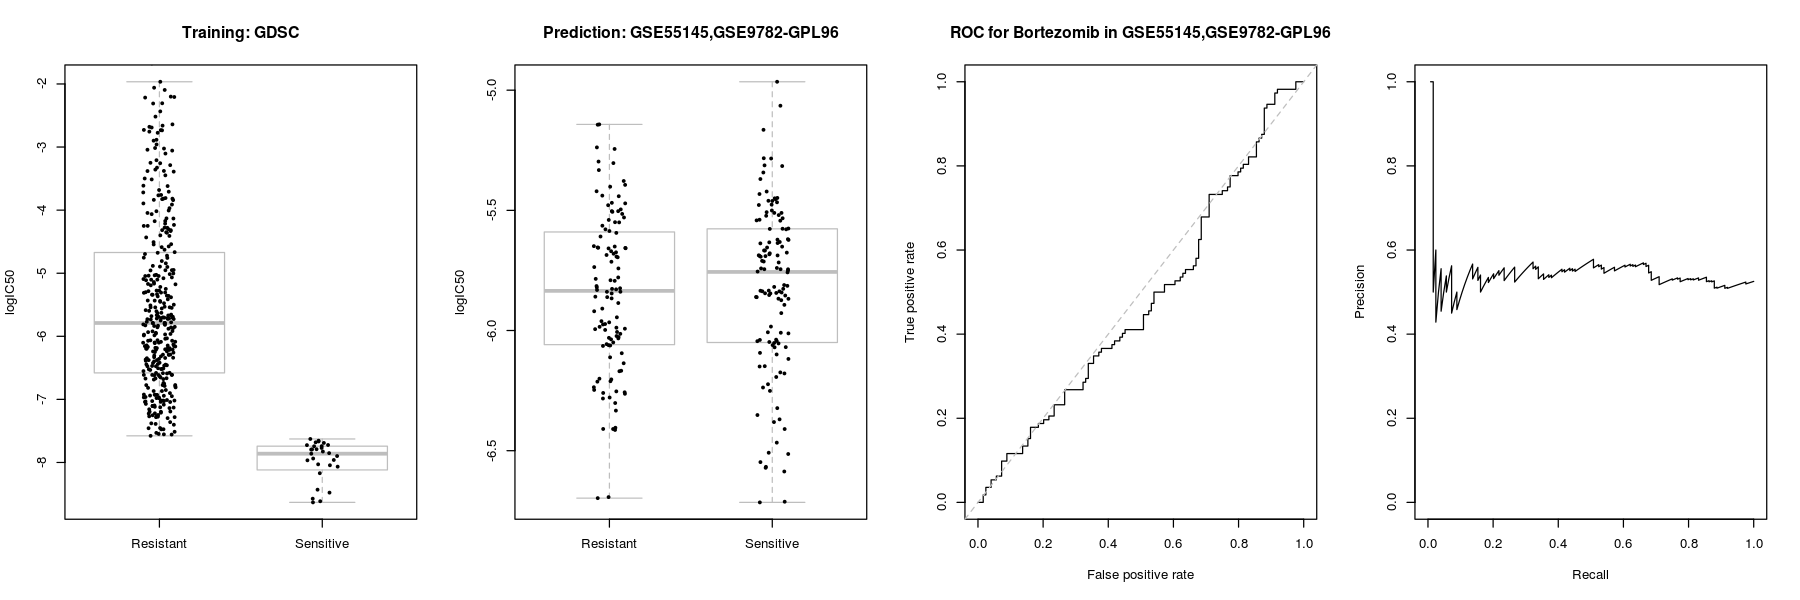


AUPRC:    0.748065669139916
AUPRC Permuatation p-value:    0.9286
average AUPRC in permutations:    0.8; P/(P+N):0.8


GSE6434,GSE25065,GSE28796,TCGA Docetaxel
genes in training cohort: 8119	samples: 829
genes in testing cohort: 8119	samples: 103
shared:8119
S:65 R:38
AUC:    0.554251012145749
ROC Permuatation p-value:    0.1757
average AUC in permutations:    0.499267611336032


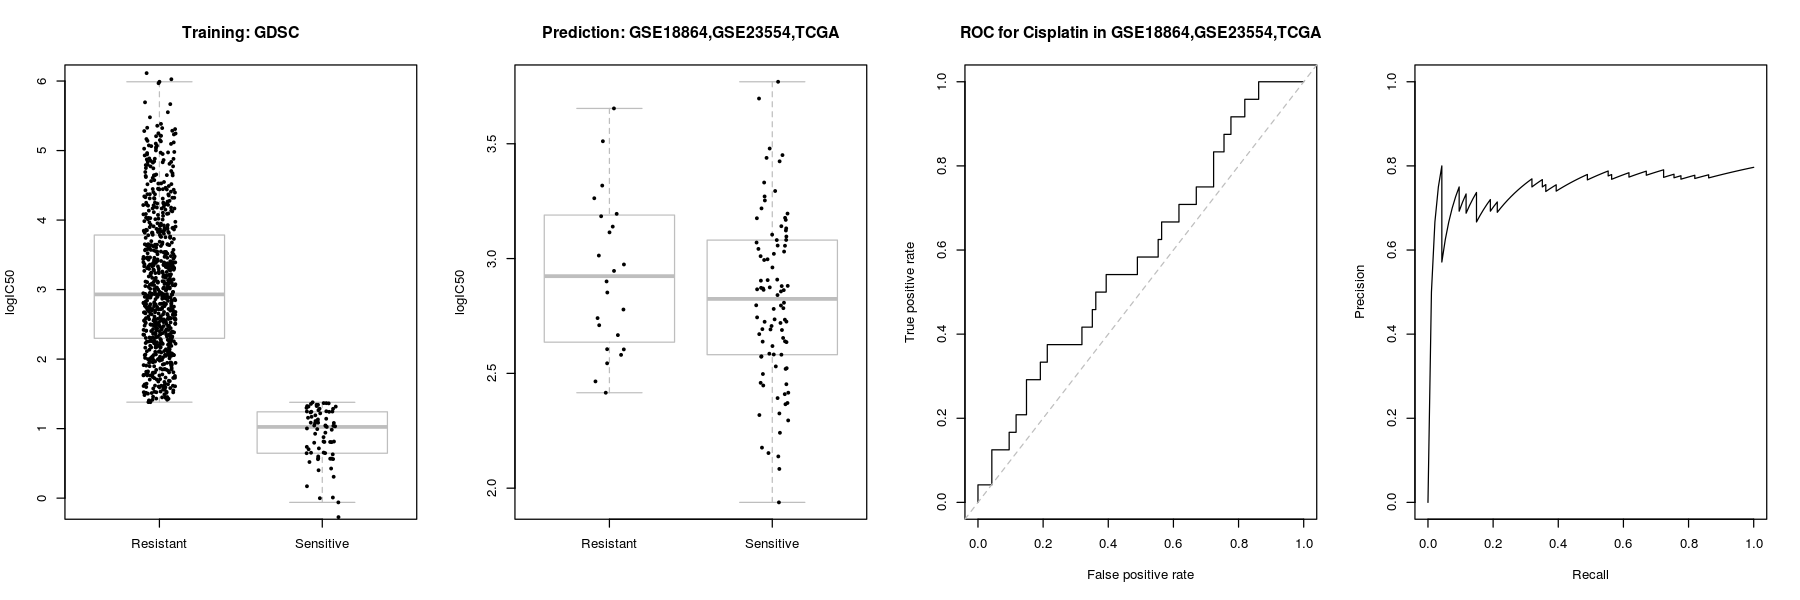


AUPRC:    0.607461560292718
AUPRC Permuatation p-value:    0.7285
average AUPRC in permutations:    0.64; P/(P+N):0.63


GSE15622,GSE22513,GSE25065,TCGA,PDX Paclitaxel
genes in training cohort: 11731	samples: 389
genes in testing cohort: 11731	samples: 196
shared:11731
S:105 R:91
AUC:    0.533437990580848
ROC Permuatation p-value:    0.2094
average AUC in permutations:    0.499912087912088


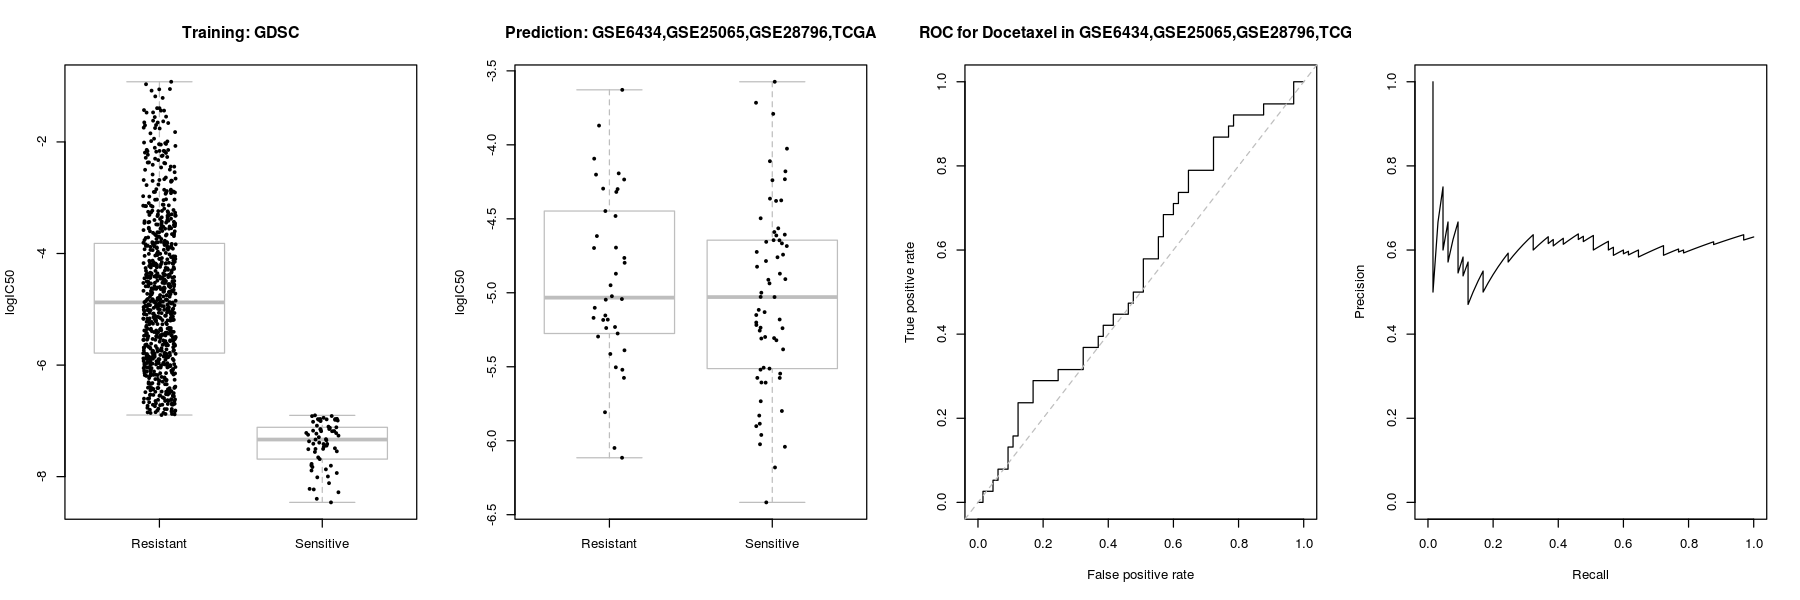


AUPRC:    0.518488778640108
AUPRC Permuatation p-value:    0.7294
average AUPRC in permutations:    0.54; P/(P+N):0.54




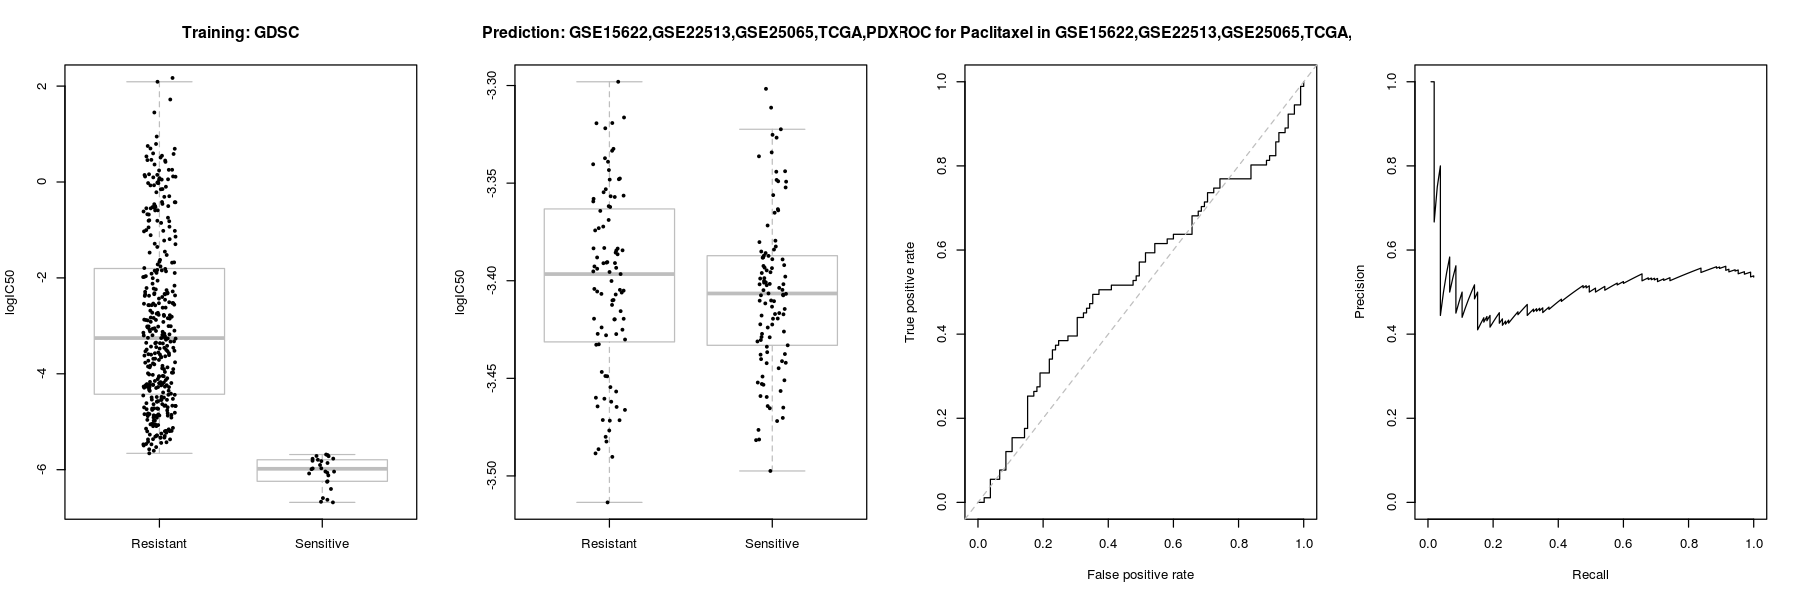

In [5]:
results_table <- list()
ds_names <- c()
for (pair in pairs){
    drug<- pair$"drug"
    cohort <- pair$"cohort"
    testDataFile <- paste0(root_dir,"/exprs/",cohort,"_exprs.z.",drug,".tsv")
    testResponseFile <- paste0(root_dir,"/response/",cohort,"_response.",drug,".tsv")

    trainingDataFile <- paste0(root_dir,"/exprs/","GDSC","_exprs.z.",drug,".tsv")
    trainingResponseFile <- paste0(root_dir,"/response/","GDSC","_response.",drug,".tsv")

    res <- run_Geelehers_method(testDataFile,testResponseFile,trainingDataFile,trainingResponseFile,
                           powTransP=powTransP,lowVarGeneThr=lowVarGeneThr,cohort=cohort,drug=drug)
    res <- c(res$"AUC",res$"AUC_pval",res$"AUPRC",res$"AUPRC_pval",res$"P_freq",res$"S",res$"R")
    ds_names <- c(ds_names, paste0(cohort,"_",drug))
    results_table  <- c(results_table , list(res))
}

results_table  <- plyr::ldply(results_table)
colnames(results_table) <- c("AUC","AUC_pval","AUPRC","AUPRC_pval","P_freq","S","R")
row.names(results_table) <-  ds_names


In [6]:
results_table 

,AUC,AUC_pval,AUPRC,AUPRC_pval,P_freq,S,R
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
"GSE55145,GSE9782-GPL96_Bortezomib",0.4783266,0.7129,0.5444624,0.3207,0.53,124,112
"GSE18864,GSE23554,TCGA_Cisplatin",0.5842199,0.0973,0.7480657,0.9286,0.80,94,24
"GSE6434,GSE25065,GSE28796,TCGA_Docetaxel",0.5542510,0.1757,0.6074616,0.7285,0.63,65,38
"GSE15622,GSE22513,GSE25065,TCGA,PDX_Paclitaxel",0.5334380,0.2094,0.5184888,0.7294,0.54,105,91


In [7]:
sessionInfo()

R version 3.4.1 (2017-06-30)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 16.04.1 LTS

Matrix products: default
BLAS: /home/olga/anaconda2/lib/R/lib/libRblas.so
LAPACK: /home/olga/anaconda2/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] plyr_1.8.4            PRROC_1.3.1           MLmetrics_1.1.1      
 [4] GEOquery_2.46.15      Biobase_2.38.0        BiocGenerics_0.24.0  
 [7] ROCR_1.0-7            gplots_3.0.1.1        preprocessCore_1.40.0
[10] car_2.1-4             sva_3.26.0            BiocPa